In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier, cv, Pool
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [2]:
age_gender_df = pd.read_csv("alter_geschlecht.csv")
interests_df = pd.read_csv("interesse.csv")
rest_df = pd.read_csv("rest.csv")

Check Each dataframe to understand the data better and look for unknown entries

In [3]:
age_gender_null_value_stats = age_gender_df.isnull().sum(axis=0)
age_gender_null_value_stats[age_gender_null_value_stats != 0]

Series([], dtype: int64)

In [4]:
age_gender_df.head()

,id,Geschlecht,Alter
0,170727,Male,42
1,41795,Male,24
2,369321,Female,30
3,500463,Female,32
4,327695,Male,34


In [5]:
age_gender_df.describe()

,id,Alter
count,508146.000000,508146.000000
mean,254073.500000,38.808413
std,146689.259281,15.500179
min,1.000000,20.000000
25%,127037.250000,25.000000
50%,254073.500000,36.000000
75%,381109.750000,49.000000
max,508146.000000,85.000000


In [6]:
interests_null_value_stats = interests_df.isnull().sum(axis=0)
interests_null_value_stats[interests_null_value_stats != 0]

Series([], dtype: int64)

In [7]:
interests_df.head()

,id,Interesse
0,1,1.0
1,2,0.0
2,3,1.0
3,4,0.0
4,5,0.0


In [8]:
interests_df.describe()

,id,Interesse
count,381109.000000,381109.000000
mean,190555.000000,0.122563
std,110016.836208,0.327936
min,1.000000,0.000000
25%,95278.000000,0.000000
50%,190555.000000,0.000000
75%,285832.000000,0.000000
max,381109.000000,1.000000


In [9]:
rest_null_value_stats = rest_df.isnull().sum(axis=0)
rest_null_value_stats[rest_null_value_stats != 0]

Series([], dtype: int64)

In [10]:
rest_df.head()

,Fahrerlaubnis;Regional_Code;Vorversicherung;Alter_Fzg;Vorschaden;Jahresbeitrag;Vertriebskanal;Kundentreue;id
0,1;15.0;1;1-2 Year;No;2630.0;124.0;74;317635
1,1;28.0;0;1-2 Year;Yes;2630.0;125.0;213;337993
2,1;33.0;0;1-2 Year;Yes;27204.0;124.0;114;160325
3,1;46.0;1;< 1 Year;No;31999.0;152.0;251;141620
4,1;49.0;0;1-2 Year;Yes;28262.0;26.0;60;75060


In [11]:
rest_df.describe()

,Fahrerlaubnis;Regional_Code;Vorversicherung;Alter_Fzg;Vorschaden;Jahresbeitrag;Vertriebskanal;Kundentreue;id
count,508146
unique,508146
top,1;15.0;1;1-2 Year;No;2630.0;124.0;74;317635
freq,1


Properly separate features by column

In [12]:
rest_df[["Fahrerlaubnis", "Regional_Code", "Vorversicherung", "Alter_Fzg", "Vorschaden", "Jahresbeitrag", "Vertriebskanal","Kundentreue","id"]]= rest_df['Fahrerlaubnis;Regional_Code;Vorversicherung;Alter_Fzg;Vorschaden;Jahresbeitrag;Vertriebskanal;Kundentreue;id'].str.split(';', n=-1, expand=True)

In [13]:
rest_df = rest_df.drop("Fahrerlaubnis;Regional_Code;Vorversicherung;Alter_Fzg;Vorschaden;Jahresbeitrag;Vertriebskanal;Kundentreue;id", axis=1)
rest_df.head()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
0,1,15.0,1,1-2 Year,No,2630.0,124.0,74,317635
1,1,28.0,0,1-2 Year,Yes,2630.0,125.0,213,337993
2,1,33.0,0,1-2 Year,Yes,27204.0,124.0,114,160325
3,1,46.0,1,< 1 Year,No,31999.0,152.0,251,141620
4,1,49.0,0,1-2 Year,Yes,28262.0,26.0,60,75060


In [14]:
rest_df.describe()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
count,508146,508146,508146,508146,508146,508146,508146,508146,508146
unique,2,53,2,3,2,52062,157,290,508146
top,1,28.0,0,1-2 Year,Yes,2630.0,152.0,256,317635
freq,507097,141937,275076,267015,256248,86488,179523,1877,1


In [15]:
rest_df['id']= rest_df['id'].astype(int)

Merge data into a single frame for easier manipulation

In [16]:
merged_df = pd.merge(age_gender_df, rest_df, on='id', how='outer')
merged_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39


In [17]:
merged_df =pd.merge(merged_df, interests_df, on='id', how='outer')

Clean feature formatting (numerical and categorical features)

In [18]:
merged_df['Regional_Code']= merged_df['Regional_Code'].astype(float).astype(int)
merged_df['Vertriebskanal']= merged_df['Vertriebskanal'].astype(float).astype(int)
merged_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Interesse
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1.0
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0.0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1.0
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0.0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0.0


In [19]:
merged_df_null_value_stats = merged_df.isnull().sum(axis=0)
merged_df_null_value_stats[merged_df_null_value_stats != 0]

Interesse    127037
dtype: int64

In [20]:
unknown_rows= merged_df[merged_df['Interesse'].isna()]
unknown_rows.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Interesse
381109,381110,Male,25,1,11,1,< 1 Year,No,35786.0,152,53,NaN
381110,381111,Male,40,1,28,0,1-2 Year,Yes,33762.0,7,111,NaN
381111,381112,Male,47,1,28,0,1-2 Year,Yes,40050.0,124,199,NaN
381112,381113,Male,24,1,27,1,< 1 Year,Yes,37356.0,152,187,NaN
381113,381114,Male,27,1,28,1,< 1 Year,No,59097.0,152,297,NaN


Remove rows where interest of customer is unknown

In [21]:
merged_df = merged_df[merged_df['Interesse'].notna()]
merged_df_null_value_stats = merged_df.isnull().sum(axis=0)
print(merged_df_null_value_stats[merged_df_null_value_stats != 0])


Series([], dtype: int64)


In [22]:

merged_df['Interesse'] = merged_df['Interesse'].astype(bool)
merged_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Interesse
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,True
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,False
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,True
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,False
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,False


In [23]:
merged_df['Alter_Fzg'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

Create a pipeline that handles the One Hot encoding of categorical features and uses a decision tree classifier as estimator

In [24]:
categorical_cols =['Geschlecht', 'Alter_Fzg', "Vorschaden"]

categorical_pipe = Pipeline(steps=[
                            ('oh_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
dt_transformer = ColumnTransformer(transformers =[                
                                        ('categorical_pipe', categorical_pipe, categorical_cols)
],
                                        remainder = 'drop',
                                        n_jobs =-1)
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier_pipeline = make_pipeline(dt_transformer, dt_classifier)

In [25]:
X = merged_df.drop(['Interesse'],axis=1)
y= merged_df['Interesse']

Perform stratified cross validation for balanced class representation and investigate log loss of model

In [165]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
#dt_classifier_scores= 
dt_cv=cross_validate(dt_classifier_pipeline,X,y,cv=skf,verbose=1,return_train_score=True,return_estimator=True,scoring = ['neg_log_loss']) #'accuracy'])


In [166]:
dt_cv

{'fit_time': array([1.67853665, 1.36667633, 1.31438851, 1.29206705]),
 'score_time': array([0.39347243, 0.26185369, 0.28279948, 0.26007509]),
 'estimator': [Pipeline(steps=[('columntransformer',
                   ColumnTransformer(n_jobs=-1,
                                     transformers=[('categorical_pipe',
                                                    Pipeline(steps=[('oh_encoder',
                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                   sparse_output=False))]),
                                                    ['Geschlecht', 'Alter_Fzg',
                                                     'Vorschaden'])])),
                  ('decisiontreeclassifier',
                   DecisionTreeClassifier(random_state=42))]),
  Pipeline(steps=[('columntransformer',
                   ColumnTransformer(n_jobs=-1,
                                     t

In [167]:
print(f"Train log loss {dt_cv['train_neg_log_loss']*-1}")
print(f"Test log loss{dt_cv['test_neg_log_loss']*-1}")

#print(f"Train accuracy {dt_cv['train_accuracy']}")
#print(f"Test accuracy{dt_cv['test_accuracy']}")

Train log loss [0.28749705 0.28748678 0.28792918 0.28783137]
Test log loss[0.28829982 0.28832462 0.2869936  0.28728164]


In [168]:
params = {
    'loss_function': 'Logloss',
    'iterations': 75,
    'learning_rate': 0.5,
}

In [169]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )

In [170]:
cat_pool = Pool(data=X,label =y,cat_features=categorical_cols)

In [ ]:
cv_data = cv(
    params = params,
    pool = cat_pool,
    fold_count=4,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

print_cv_summary(cv_data)   

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]

bestTest = 0.2653395165
bestIteration = 45

Training on fold [1/4]


In [117]:
catboost_model = CatBoostClassifier
iterations_values = [100, 200]
depth_values = [6, 8]
learning_rate_values = [0.1, 0.05, 0.01]
 
best_score = 0  # Initialize the best score
best_params = {}  # Initialize the best hyperparameters
 
# Define cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [118]:
cross_val_score(dt_classifier_pipeline,X,y,cv=skf,verbose=1)

array([0.87743236, 0.87743107, 0.87744157, 0.87744157])

In [119]:
mappings = {
    '> 2 Years': '2',
    '1-2 Year': '1',
    '<1 Year': '0'
}  
merged_df['Alter_Fzg']= merged_df['Alter_Fzg'].map(mappings)

In [120]:
merged_df['Alter_Fzg']= merged_df['Alter_Fzg'].fillna('0')
merged_df['Alter_Fzg']= merged_df['Alter_Fzg'].astype(int)

In [121]:
merged_df['Alter_Fzg'].unique()

array([2, 1, 0])

In [122]:
merged_df['Kundentreue']= merged_df['Kundentreue'].astype(int)
merged_df['Jahresbeitrag']= merged_df['Jahresbeitrag'].astype(float)
merged_df['Fahrerlaubnis']= merged_df['Fahrerlaubnis'].astype(bool)
merged_df['Vorversicherung']= merged_df['Vorversicherung'].astype(bool)
merged_df['Vorschaden']= merged_df['Vorschaden'].astype(bool)

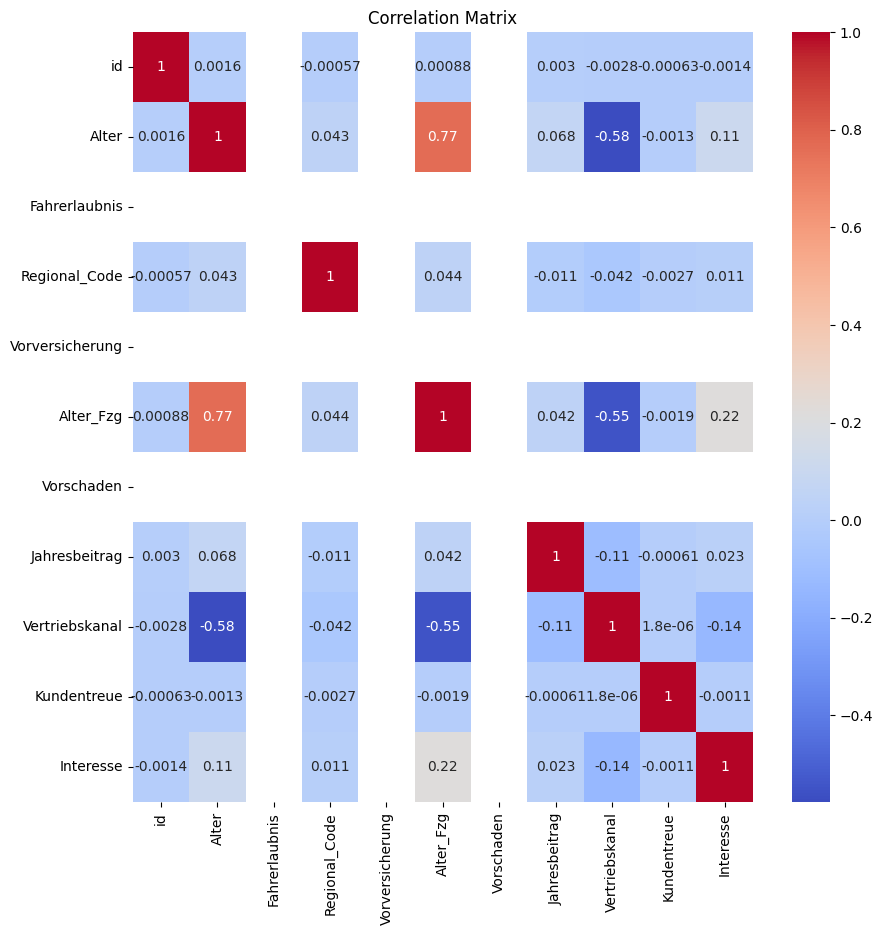

In [123]:
correlation_matrix = merged_df.corr(numeric_only=True)
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [124]:
merged_df.dtypes

id                   int64
Geschlecht          object
Alter                int64
Fahrerlaubnis         bool
Regional_Code        int32
Vorversicherung       bool
Alter_Fzg            int32
Vorschaden            bool
Jahresbeitrag      float64
Vertriebskanal       int32
Kundentreue          int32
Interesse             bool
dtype: object

In [125]:
merged_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Interesse
0,1,Male,44,True,28,True,2,True,40454.0,26,217,True
1,2,Male,76,True,3,True,1,True,33536.0,26,183,False
2,3,Male,47,True,28,True,2,True,38294.0,26,27,True
3,4,Male,21,True,11,True,0,True,28619.0,152,203,False
4,5,Female,29,True,41,True,0,True,27496.0,152,39,False


In [126]:
dt_classifier = DecisionTreeClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=42,  
                                   test_size=0.25,  
                                   shuffle=True) 
